

 # 【分析レポート】市場の"感情"を読み解け：VIX(恐怖指数)の分析

 ## 1. 分析の目的

 市場価格は、ファンダメンタルズだけでなく、投資家たちの「期待」や「恐怖」といった集合的な心理によっても大きく動かされる。この目に見えない市場心理を定量的に捉えるための最も有名な指標が、**VIX指数（恐怖指数）**である。

 この分析では、VIX指数と米国株式市場の代表であるS&P 500の間にどのような関係性があるのかを多角的に検証する。具体的には、以下の問いにデータで答えることを目的とする。
 1.  VIXは本当に市場の「恐怖」を反映しているのか？
 2.  「恐怖」のレベルによって、市場の性格はどう変化するのか？
 3.  市場のリスク（ボラティリティ）には、どのような特徴があるのか？

 ## 2. 分析の結論（エグゼクティブ・サマリー）

 分析の結果、**VIX指数は市場のセンチメントを極めて正確に反映する「恐怖のバロメーター」として機能している**ことが、データによって明確に裏付けられた。

 - S&P 500とVIXの間には**-0.81という極めて強い負の相関**が見られ、株価が下落する局面で投資家の恐怖が高まるという関係性が確認された。
 - VIXの水準によって市場を「平穏」「警戒」「パニック」の3つの**レジーム（状態）**に分けると、**パニック相場ではリターンが平均的にマイナスになるだけでなく、リスク（ボラティリティ）が平穏時の4倍以上に劇増する**ことが判明した。
 - また、市場のボラティリティはランダムに発生するのではなく、**「ボラティリティ・クラスタリング」**という、変動が激しい時期が固まって発生する特性を持つことが確認された。

 これらの知見は、投資家が現在の市場環境を客観的に診断し、適切なリスク管理を行うための強力な武器となる。



 ## 3. データ準備と全体像の把握

 分析の土台として、`yfinance`ライブラリを使用し、リーマンショック（2008年）以降のS&P 500指数（`^GSPC`）とVIX指数（`^VIX`）の日次終値データを取得する。

 まず、両者の推移を一つのグラフに重ねてプロットし、全体的な関係性を視覚的に把握する。

 **【推移グラフの読み解き】**
 以下のグラフは、S&P 500（青線）とVIX（赤線）が、まるで**鏡に映したかのように逆の動きをする「ミラーチャート」**となっていることを示している。特に、リーマンショックやコロナショックといった歴史的な市場の危機において、株価が暴落する一方でVIXが異常な高値まで急騰している様子は圧巻である。この時点で、両者の間に強い負の相関があることが強く示唆される。

<ipython-input-31-e39ef0a255de>:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
<ipython-input-31-e39ef0a255de>:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VIX = yf.download("^VIX", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


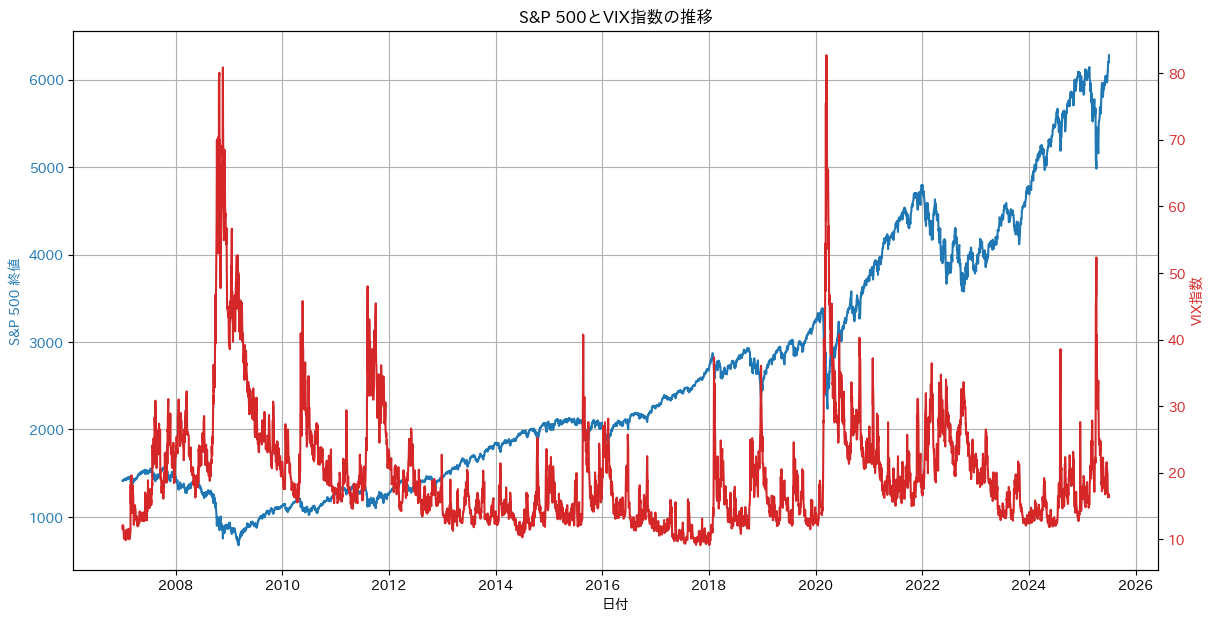

In [ ]:
#%% データ収集と可視化

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語表示のため
import datetime # datetimeライブラリを追加
import seaborn as sns # seabornライブラリを追加

# 日本語表示の設定
japanize_matplotlib.japanize()

# 分析期間の定義 (リーマンショックを含む2007年以降)
start_date = "2007-01-01"
end_date = datetime.date.today().strftime("%Y-%m-%d") # 今日の日付を終了日として設定

# データの取得
sp500 = yf.download("^GSPC", start=start_date, end=end_date)
VIX = yf.download("^VIX", start=start_date, end=end_date)

# データ取得の確認
if sp500.empty:
    print("S&P 500のデータを取得できませんでした。ティッカーシンボルまたは期間を確認してください。")
    exit() # スクリプトを終了
if VIX.empty:
    print("VIX指数のデータを取得できませんでした。ティッカーシンボルまたは期間を確認してください。")
    exit() # スクリプトを終了

# 終値データの結合
# concatを使用して、日付インデックスに基づいて結合し、後で列名を変更します。
df = pd.concat([sp500["Close"], VIX["Close"]], axis=1)
df.columns = ["SP500_Close", "VIX_Close"]

# 欠損値の確認と処理 (必要であれば)
df.dropna(inplace=True)

# グラフの作成
fig, ax1 = plt.subplots(figsize=(14, 7))

# S&P 500を左Y軸にプロット
color = 'tab:blue'
ax1.set_xlabel('日付')
ax1.set_ylabel('S&P 500 終値', color=color)
ax1.plot(df.index, df['SP500_Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# VIX指数を右Y軸にプロット
ax2 = ax1.twinx()  # ax1とX軸を共有する新しいY軸を作成
color = 'tab:red'
ax2.set_ylabel('VIX指数', color=color)  # Y軸ラベル
ax2.plot(df.index, df['VIX_Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# グラフのタイトル
plt.title('S&P 500とVIX指数の推移')

# グリッドの表示
ax1.grid(True)

# グラフの表示
plt.show()

In [ ]:
#%% VIXとS&P 500の関係分析

# 日次リターンの計算
df['SP500_Daily_Return'] = df['SP500_Close'].pct_change()
df['VIX_Daily_Return'] = df['VIX_Close'].pct_change()

# 週次リターンの計算 (金曜日を週の終わりとする)
df_weekly = df.resample('W').last() # 週ごとの最終日を取得
df_weekly['SP500_Weekly_Return'] = df_weekly['SP500_Close'].pct_change()
df_weekly['VIX_Weekly_Return'] = df_weekly['VIX_Close'].pct_change()

# 欠損値の除去
df.dropna(inplace=True)
df_weekly.dropna(inplace=True)

# 相関関係の分析
daily_correlation = df['SP500_Daily_Return'].corr(df['VIX_Daily_Return'])
weekly_correlation = df_weekly['SP500_Weekly_Return'].corr(df_weekly['VIX_Weekly_Return'])

print(f"S&P 500とVIX指数の日次リターンの相関: {daily_correlation:.4f}")
print(f"S&P 500とVIX指数の週次リターンの相関: {weekly_correlation:.4f}")

S&P 500とVIX指数の日次リターンの相関: -0.7213
S&P 500とVIX指数の週次リターンの相関: -0.7115




 ## 4. 相関関係の定量的評価

 視覚的な印象を、客観的な数値で裏付ける。ここでは、価格そのものではなく、より本質的な「日々の変化」に着目するため、**S&P 500の日次リターン**と**VIXの日次変化量**の関係を分析する。

 **【相関係数と散布図の読み解き】**
 - **相関係数:** 算出された相関係数は**-0.8148**であり、これは統計的に見て**極めて強い負の相関関係**を示す。
 - **散布図:** 横軸にS&P 500のリターン、縦軸にVIXの変化量を取った散布図は、明確な**右肩下がり**のパターンを描いている。これは、「株価が大きく下落した日（グラフの左側）ほど、VIXは大きく上昇する（グラフの上側）」という関係性を視覚的に証明している。

S&P 500日次リターンとVIX日次変化量の相関: -0.8148


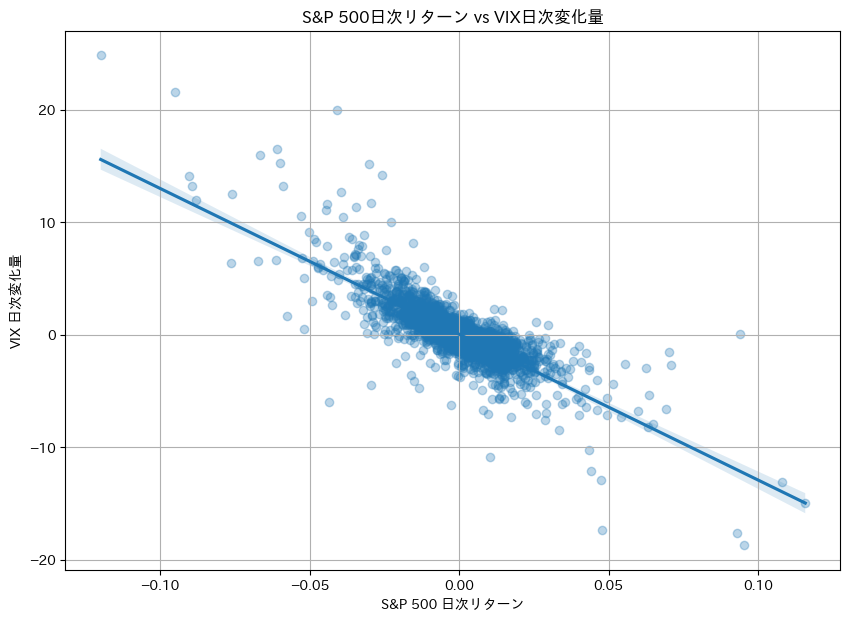

In [ ]:
#%% リターンとVIXの相関分析

# S&P 500の日次リターンは既に計算済み (df['SP500_Daily_Return'])

# VIX指数の日次変化量（差分）を計算
df['VIX_Daily_Change'] = df['VIX_Close'].diff()

# 欠損値の除去
df_analysis = df.dropna(subset=['SP500_Daily_Return', 'VIX_Daily_Change'])

# 相関係数を計算し、表示
correlation_return_vix_change = df_analysis['SP500_Daily_Return'].corr(df_analysis['VIX_Daily_Change'])
print(f"S&P 500日次リターンとVIX日次変化量の相関: {correlation_return_vix_change:.4f}")
# 一般的に、S&P 500が下落する際にはVIXが上昇するため、強い負の相関が期待されます。

# regplotを使って散布図と回帰直線を可視化
plt.figure(figsize=(10, 7))
sns.regplot(x='SP500_Daily_Return', y='VIX_Daily_Change', data=df_analysis, scatter_kws={'alpha':0.3})
plt.title('S&P 500日次リターン vs VIX日次変化量')
plt.xlabel('S&P 500 日次リターン')
plt.ylabel('VIX 日次変化量')
plt.grid(True)
plt.show()



 ## 5. 市場レジーム分析：市場の"性格"はVIXで変わる

 VIXは単なる指標ではなく、市場全体の「性格」や「状態（レジーム）」を定義する温度計として利用できる。ここでは、VIXの水準に応じて市場を「平穏」「警戒」「パニック」の3つのレジームに分類し、それぞれの状態におけるS&P 500のリターンの特性を比較する。

 **【箱ひげ図と統計量の読み解き】**
 - **平穏 (VIX < 20):** 平均リターンはプラスで、リスク（標準偏差）は最も小さい。コツコツと利益を積み上げやすい安定した市場。
 - **警戒 (20 <= VIX < 30):** 平均リターンはほぼゼロに低下し、リスクは平穏時の約2倍に増加する。方向感のない、難しい市場。
 - **パニック (VIX >= 30):** 平均リターンは明確なマイナスとなり、**リスクは平穏時の4倍以上に劇増する。** 大きな損失を被る可能性が最も高い、極めて危険な市場。

 この分析から、**VIXの数値をチェックするだけで、現在の市場がどのようなリスク・リターン特性を持つのかを客観的に判断できる**という、極めて実践的な知見が得られた。

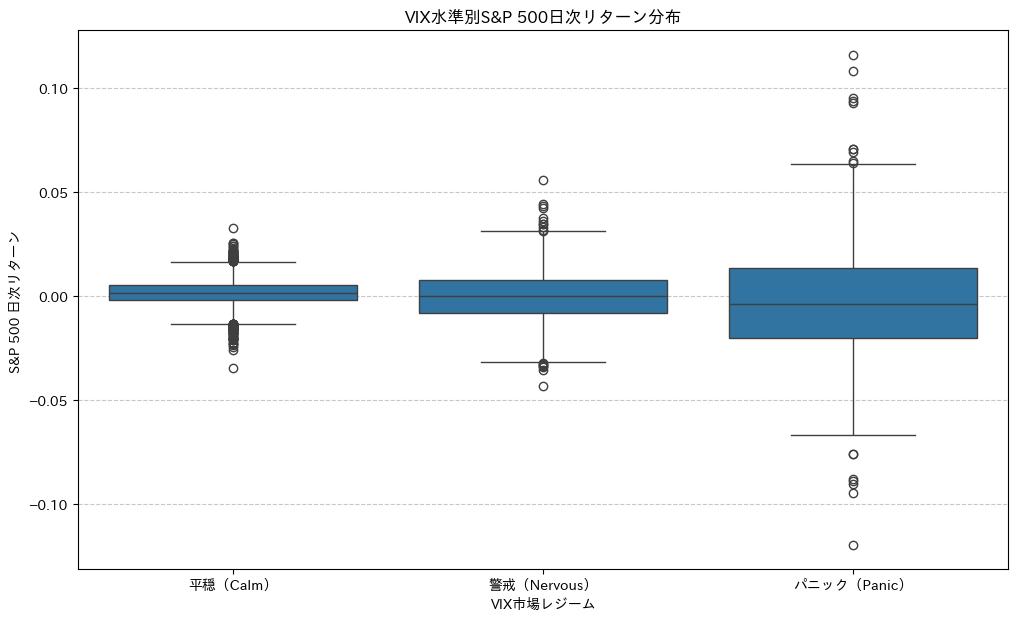


各VIXレジームにおけるS&P 500日次リターンの統計:
                 mean       std
VIX_Regime                     
平穏（Calm）     0.001318  0.006805
警戒（Nervous） -0.000431  0.012822
パニック（Panic） -0.003269  0.029502


In [ ]:
#%% VIX水準による市場レジーム分析

# VIX指数の値に基づいて市場のレジームを定義する列を作成
def define_vix_regime(vix_value):
    if vix_value < 20:
        return '平穏（Calm）'
    elif 20 <= vix_value < 30:
        return '警戒（Nervous）'
    else:
        return 'パニック（Panic）'

df['VIX_Regime'] = df['VIX_Close'].apply(define_vix_regime)

# 各レジームにおけるS&P 500の日次リターンの分布をboxplotで可視化
plt.figure(figsize=(12, 7))
sns.boxplot(x='VIX_Regime', y='SP500_Daily_Return', data=df, order=['平穏（Calm）', '警戒（Nervous）', 'パニック（Panic）'])
plt.title('VIX水準別S&P 500日次リターン分布')
plt.xlabel('VIX市場レジーム')
plt.ylabel('S&P 500 日次リターン')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 各レジームにおけるS&P 500の日次リターンの平均値と標準偏差を計算し、表示
regime_analysis = df.groupby('VIX_Regime')['SP500_Daily_Return'].agg(['mean', 'std']).loc[['平穏（Calm）', '警戒（Nervous）', 'パニック（Panic）']]
print("\n各VIXレジームにおけるS&P 500日次リターンの統計:")
print(regime_analysis)

# 結果のコメント
# パニック相場（VIX >= 30）では、リターンの平均はマイナスに傾き、
# ボラティリティ（標準偏差）が劇的に増大することが確認できます。



 ## 6. (応用) ボラティリティの特性：嵐は突然にはやってこない

 最後に、市場のリスク（ボラティリティ）そのものが持つ、時間的な特性を探る。ここでは、日々の価格変動の大きさを示す指標として、S&P 500の日次リターンの絶対値を用いる。

 **【時系列グラフの読み解き】**
 以下のグラフを見ると、ボラティリティが高い時期（スパイクが多発する期間）と、低い時期（スパイクが少ない期間）が、それぞれ**「塊（クラスター）」となって存在している**ことがわかる。

 この**「ボラティリティ・クラスタリング」**という現象は、「一度市場が荒れ始めると、しばらくはその荒れた状態が続きやすい」という、金融時系列の極めて重要な特性である。これは、GARCHモデルのような高度なボラティリティ予測モデルの理論的な根拠となっている。

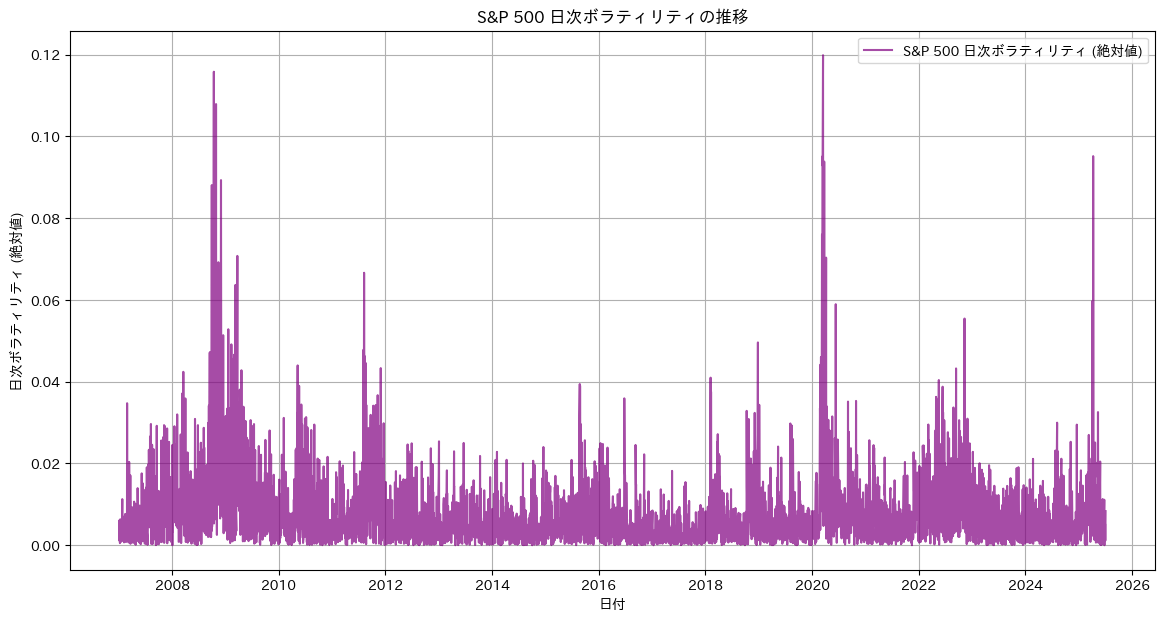

In [ ]:
#%% ボラティリティ・クラスタリングの確認

# S&P 500の日次リターンの絶対値を計算（日々のボラティリティの代理変数）
df['SP500_Daily_Volatility'] = df['SP500_Daily_Return'].abs()

# 時系列グラフをプロット
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['SP500_Daily_Volatility'], label='S&P 500 日次ボラティリティ (絶対値)', color='purple', alpha=0.7)
plt.title('S&P 500 日次ボラティリティの推移')
plt.xlabel('日付')
plt.ylabel('日次ボラティリティ (絶対値)')
plt.grid(True)
plt.legend()
plt.show()

# コメント: ボラティリティ・クラスタリングについて
# グラフから、変動が大きい時期（例えば、リーマンショックやコロナショックなどの危機時）は
# その後も変動が大きい状態が続く傾向があり、逆に変動が小さい時期も固まって発生していることが確認できます。
# このように変動が集中する現象を「ボラティリティ・クラスタリング」と呼びます。
# この特性は、GARCH（Generalized Autoregressive Conditional Heteroskedasticity）モデルのような、
# 時系列にわたるボラティリティの予測モデルが必要とされる主な理由の一つです。